## Data Loading and Preprocessing

In [57]:
import pandas as pd

raw_data: pd.DataFrame = pd.read_csv('data/fake_job_postings.csv')
raw_data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [58]:
# Create new dataframe with concatenated text columns and fraudulent label
data = pd.DataFrame({
  'job_description': raw_data[['company_profile', 'description', 'requirements', 'benefits']].fillna('').agg(' '.join, axis=1),
  'fraudulent': raw_data['fraudulent']
})
data

,job_description,fraudulent
0,"We're Food52, and we've created a groundbreaki...",0
1,"90 Seconds, the worlds Cloud Video Production ...",0
2,Valor Services provides Workforce Solutions th...,0
3,Our passion for improving quality of life thro...,0
4,SpotSource Solutions LLC is a Global Human Cap...,0
...,...,...
17875,Vend is looking for some awesome new talent to...,0
17876,WebLinc is the e-commerce platform and service...,0
17877,We Provide Full Time Permanent Positions for m...,0
17878,Nemsia Studios is looking for an experienced ...,0


Remove duplicated `job_description` from the data.

In [59]:
data = data.drop_duplicates(subset=['job_description'], keep='first')
data


,job_description,fraudulent
0,"We're Food52, and we've created a groundbreaki...",0
1,"90 Seconds, the worlds Cloud Video Production ...",0
2,Valor Services provides Workforce Solutions th...,0
3,Our passion for improving quality of life thro...,0
4,SpotSource Solutions LLC is a Global Human Cap...,0
...,...,...
17873,RESPONSIBILITIES:Will facilitate the recruiti...,0
17875,Vend is looking for some awesome new talent to...,0
17876,WebLinc is the e-commerce platform and service...,0
17877,We Provide Full Time Permanent Positions for m...,0


## Data Exploration

Plot a histogram of the lengths of the `job_description` for fraudulent and non-fraudulent job postings

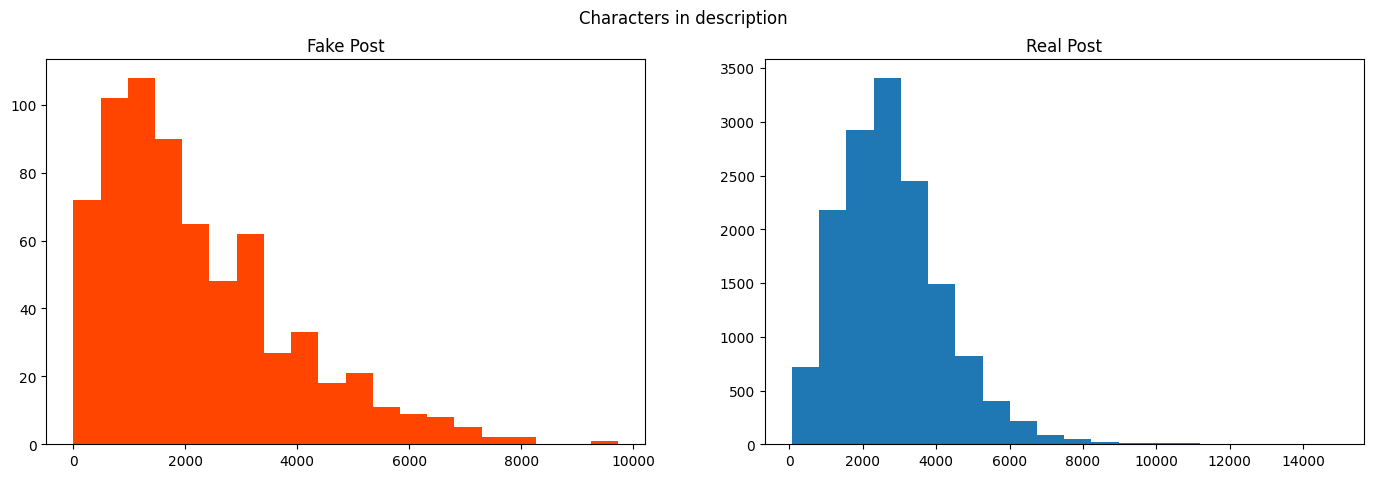

In [60]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length = data[data["fraudulent"] == 1]["job_description"].str.len()
ax1.hist(length, bins=20, color="orangered")

ax1.set_title("Fake Post")
length = data[data["fraudulent"] == 0]["job_description"].str.len()
ax2.hist(length, bins=20)
ax2.set_title("Real Post")
fig.suptitle("Characters in description")
plt.show()

In [62]:
data['job_description'].str.len().groupby(data['fraudulent']).mean()

fraudulent
0    2786.759905
1    2228.402047
Name: job_description, dtype: float64

## Latent Semantic Analysis

First we split the data and oversample the fraudulent job postings to balance the dataset.

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['job_description'], data['fraudulent'], test_size=0.2, random_state=42, stratify=data['fraudulent']
)

# Convert to DataFrame for easy manipulation
train_df = pd.DataFrame({'job_description': X_train, 'fraudulent': y_train})

# Separate fraudulent (y=1) and non-fraudulent (y=0) samples
fraudulent_df = train_df[train_df['fraudulent'] == 1]
non_fraudulent_df = train_df[train_df['fraudulent'] == 0]
print(fraudulent_df.shape, non_fraudulent_df.shape)

# Oversample each fraudulent job description exactly 21 times
fraudulent_df_oversampled = pd.concat([fraudulent_df] * 21, ignore_index=True)

# Combine the oversampled fraudulent data with the original non-fraudulent data
train_df_oversampled = pd.concat([non_fraudulent_df, fraudulent_df_oversampled], ignore_index=True)

# Shuffle the data
train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract the oversampled X_train and y_train
X_train = train_df_oversampled['job_description']
y_train = train_df_oversampled['fraudulent']

# Check new class distribution
print(y_train.value_counts())

(547, 2) (11832, 2)
fraudulent
0    11832
1    11487
Name: count, dtype: int64


Number of fraudulent and non-fraudulent job postings in the testing set

In [65]:
y_test.value_counts()

fraudulent
0    2958
1     137
Name: count, dtype: int64

Make sure the training set and testing set are not overlapping.

In [72]:
# Convert Series to sets for intersection operation
train_set = set(X_train.values)
test_set = set(X_test.values)

# Find overlap between train and test sets
overlap = train_set.intersection(test_set)

# Print results
print(f"Number of overlapping descriptions: {len(overlap)}")
if len(overlap) > 0:
  print("Warning: Train and test sets have overlapping data!")
else:
  print("Train and test sets are properly separated with no overlap.")

Number of overlapping descriptions: 0
Train and test sets are properly separated with no overlap.


Use `TfidfVectorizer` to convert text data into vectors

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=60000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(X_train_vec.shape)
print(y_train.shape)

(23319, 60000)
(23319,)


In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3000)

X_train_pca = pca.fit_transform(X_train_vec)
X_test_pca = pca.transform(X_test_vec)

X_train_vec = X_train_pca
X_test_vec = X_test_pca

np.float64(0.9169323218757455)

Percents of variance explained by the PCA components

In [42]:
print(pca.explained_variance_ratio_.sum())

0.9169323218757455


In [ ]:
import pickle
filename = 'models/pca.sav'
pickle.dump(pca, open(filename, 'wb'))

In [74]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate(y_test, y_pred):
  print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'Confusion matrix:\n {confusion_matrix(y_test, y_pred)}')
  print(f"{classification_report(y_test, y_pred)}")

In [75]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vec, y_train)
evaluate(y_test, model.predict(X_test_vec))

Accuracy: 0.9735056542810986
Confusion matrix:
 [[2902   56]
 [  26  111]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2958
           1       0.66      0.81      0.73       137

    accuracy                           0.97      3095
   macro avg       0.83      0.90      0.86      3095
weighted avg       0.98      0.97      0.97      3095



In [76]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_vec, y_train)
evaluate(y_test, model.predict(X_test_vec))

Accuracy: 0.9760904684975767
Confusion matrix:
 [[2950    8]
 [  66   71]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2958
           1       0.90      0.52      0.66       137

    accuracy                           0.98      3095
   macro avg       0.94      0.76      0.82      3095
weighted avg       0.97      0.98      0.97      3095



In [77]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_vec, y_train)
evaluate(y_test, model.predict(X_test_vec))

Accuracy: 0.9499192245557351
Confusion matrix:
 [[2821  137]
 [  18  119]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2958
           1       0.46      0.87      0.61       137

    accuracy                           0.95      3095
   macro avg       0.73      0.91      0.79      3095
weighted avg       0.97      0.95      0.96      3095



In [78]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(X_train_vec, y_train)

evaluate(y_test, model.predict(X_test_vec))

Accuracy: 0.9831987075928917
Confusion matrix:
 [[2938   20]
 [  32  105]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2958
           1       0.84      0.77      0.80       137

    accuracy                           0.98      3095
   macro avg       0.91      0.88      0.90      3095
weighted avg       0.98      0.98      0.98      3095



In [50]:
# Run an example prediction

def predict_fraudulent(job_description: str):
  job_description_vec = vectorizer.transform([job_description])
  res = model.predict(job_description_vec)
  return 'Fraud' if res[0] == 1 else 'Legit'

print(predict_fraudulent("We are looking for a software engineer to join our team"))
print(predict_fraudulent("Pay us 1000$ and we will make you a millionaire in a week"))
print(predict_fraudulent("We are looking for a software engineer to join our team. Pay us 1000$ and we will make you a millionaire in a week"))
print(predict_fraudulent("We are the second best university in the world, you just need to pay us £40000 per year for 3 years and then you will receive a piece of paper that guarantees you a job"))
print(predict_fraudulent("""
As a Software Engineering Intern, you will work side-by-side with your mentor and teammates to build real-world applications. You will work on projects that further develop and optimize our systems and see contributions in real-time - testing and shipping your code to production. In our business, where the markets are always evolving, each day brings fresh challenges to solve.

What you'll do

Mentored by Optiver engineers, you will play a key role in advancing our world-class trading systems, working on projects that push the boundaries of performance and efficiency. You will:

Deep dive into trading fundamentals, from theoretical concepts to financial markets, strategies and cutting-edge technology
Work closely with senior engineers and traders to design, develop, test, and ship your code to production
Tackle complex, real-world problems to enhance your critical thinking and problem-solving skills
Discover examples of potential projects here.

Based on your performance during the internship, you could receive an offer to join our firm full-time after your studies.

What you'll get

You'll join a culture of collaboration and excellence, where you'll be surrounded by curious thinkers and creative problem solvers. Motivated by a passion for continuous improvement, you'll thrive in a supportive, high-performing environment alongside talented colleagues, working collectively to tackle the toughest problems in the financial markets.

In addition, you'll receive:

A highly competitive internship compensation package
Optiver-covered flights and accommodations for the duration of the internship
Extensive office perks, including breakfast and lunch, world-class barista coffee and Friday afternoon drinks
The opportunity to participate in sports and leisure activities, along with social events exclusively organized for your intern cohort
Who you are

Penultimate year student in Computer Science, Computer Engineering or equivalent, with the ability to work full time upon graduation in 2026
Passionate for clean code, simple, well-architected systems and continuous improvement
Proficient in industry-standard coding languages such as C++, Python, or Java, with a strong understanding of underlying computer architecture and system operations
Have an entrepreneurial attitude and an interest in the financial industry
An analytical mindset and strong problem-solving skills
Able to work closely with other developers, traders and business operations
Diversity statement

Optiver is committed to diversity and inclusion.

We encourage applications from candidates from any and all backgrounds, and we welcome requests for reasonable adjustments during the process to ensure that you can best demonstrate your abilities. Please let us know if you would like to request any reasonable adjustments by contacting the Recruitment team via reasonableadjustments@optiver.com.

For answers to some of our most frequently asked questions, refer to our Campus FAQs.

For applicants based in India, our entry route is via the placement office internship hiring season (July/August).

*We accept one application per role per year. If you have previously applied to this position during this season and have been unsuccessful, you can reapply once the next recruitment season begins in 2025.
"""))
print(predict_fraudulent("""
Arm drive court sure vote. Earn $5000/week! Immediate hiring. Contact now at david27@gmail.com.
Basic knowledge in live, no degree required. Flexible hours.
"""))
print(predict_fraudulent("Pay us 1000$ and we will make you a millionaire in a week, this is definitely not a scam, we are super legit. Trust us. Your machine learning model is wrong. We are not fraudulent. We are the best."))


Legit
Fraud
Fraud
Legit
Legit
Legit
Legit


In [51]:
# Generated by ChatGPT
print(
    predict_fraudulent(
        """
Job Title: Remote Data Entry Clerk - No Experience Required
Company: Global Solutions Ltd.
Location: Remote
Salary: $30–$40 per hour
Job Type: Full-time, Part-time

Job Description:
We are seeking highly motivated individuals to join our remote data entry team. No prior experience is needed—we provide full training! Your role will involve inputting data into our system, ensuring accuracy, and maintaining records.

Responsibilities:

Enter and verify data accurately
Maintain digital records and files
Follow instructions and meet daily targets
Requirements:

Basic computer skills
Strong attention to detail
Ability to work independently
No prior experience necessary
"""
    )
)

print(
    predict_fraudulent(
        """
Job Title: Junior Software Developer – Work From Home
Company: TechNova Solutions
Location: Remote
Salary: $120,000–$140,000 per year

Job Description:
We are looking for talented developers to join our fast-growing remote team. Work from home with flexible hours and earn top industry salaries.

Responsibilities:

Develop and maintain applications using Python and Java
Collaborate with a global team on innovative projects
Write clean, scalable code
Requirements:

Proficiency in Python, Java, or C++
Strong problem-solving skills
Willingness to undergo a short remote training session
Next Steps:
To begin, you will need a company-approved laptop. We require a refundable $500 security deposit to issue your work laptop and credentials.
"""
    )
)
print(
    predict_fraudulent(
        """
Dear [Candidate’s Name],

We reviewed your resume and believe you are an excellent fit for a high-paying remote project management position. The company is urgently hiring, and we would like to proceed with your onboarding.

Job Highlights:

Position: Remote Project Manager
Salary: $150,000–$180,000 per year
Benefits: Full health coverage, unlimited PTO
Company: Fortune 500 partner
To accept this offer, please submit your personal details and a small processing fee of $50 to finalize your application. This fee is fully refundable.

Best Regards,
[Fake Recruiter Name]
Senior Hiring Manager

"""
    )
)

Legit
Legit
Legit
